In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")
                
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

# viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12.7,10.27)})

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import os
#os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
def getTCGA(disease):
    path = "/srv/nas/mk2/projects/pan-cancer/TCGA_CCLE_GCP/TCGA/TCGA_{}_counts.tsv.gz"
    files = [path.format(d) for d in disease]
    return files


def readGCP(files, biotype='protein_coding', mean=True):
    """
    Paths to count matrices.
    """
    data_dict = {}
    for f in files:
        key = os.path.basename(f).split("_")[1]
        data = pd.read_csv(f, sep='\t', index_col=0)
        # transcript metadata
        meta = pd.DataFrame([row[:-1] for row in data.index.str.split("|")],
                            columns=['ENST', 'ENSG', 'OTTHUMG', 'OTTHUMT', 'GENE-NUM', 'GENE', 'BP', 'BIOTYPE'])
        meta = pd.MultiIndex.from_frame(meta)
        data.index = meta
        # subset transcripts
        data = data.xs(key=biotype, level='BIOTYPE')
        data = data.droplevel(['ENST', 'ENSG', 'OTTHUMG', 'OTTHUMT', 'GENE-NUM', 'BP'])
        # average gene expression of splice variants
        data = data.T
        if mean:
            data = data.groupby(by=data.columns, axis=1).mean()
        data_dict[key] = data
    return data_dict


def uq_norm(df, q=0.75):
    """
    Upper quartile normalization of GEX for samples.
    """
    quantiles = df.quantile(q=q, axis=1)
    norm = df.divide(quantiles, axis=0)
    return norm

In [4]:
base = "/srv/nas/mk2/projects/pan-cancer/TCGA_CCLE_GCP"
disease = ['KIRC']#, 'LUAD', 'KIRC', 'THCA', 'PRAD', 'SKCM']

tcga_files = getTCGA(disease)
tcga_meta = pd.read_csv(os.path.join(base, "TCGA/TCGA_GDC_ID_MAP.tsv"), sep="\t")
tcga_raw = readGCP(tcga_files, mean=True)

In [5]:
# combine samples
tcga_raw = pd.concat(tcga_raw.values())

## Normalization

In [6]:
# Upper quartile normalization
tcga_raw = uq_norm(tcga_raw)

In [7]:
# log norm
tcga = tcga_raw.transform(np.log1p)

In [8]:
# downsample
#tcga = tcga_raw.sample(n=40000, axis=1)

# Model

### Experimental Setup

In [9]:
from collections import OrderedDict 
hierarchy = OrderedDict({'Disease':['KIRC'],# 'LUAD', 'KIRC', 'THCA', 'PRAD', 'SKCM'],
                         'Sample Type':['Primary Tumor', 'Solid Tissue Normal', 'Metastatic']})

In [14]:
from dutils import Experiment
# Define experiment
exp = Experiment(meta_data=tcga_meta,
                 hierarchy=hierarchy,
                 index='CGHubAnalysisID',
                 cases='Case ID',
                 min_samples=20)
# Holdout metastatic
exp.holdout(holdout=['SKCM:Metastatic'])
# Train / Test split
exp.train_test_split(cases='Case ID')
# Return data 
train_data, train_labels = exp.get_data(tcga, subset="train", dtype=np.float32)
test_data, test_labels = exp.get_data(tcga, subset="test", dtype=np.float32)

In [15]:
b = np.random.shuffle(train_labels)

In [16]:
b

In [11]:
exp.meta_data['meta'].value_counts()
exp.holdout_meta['meta'].value_counts()

KIRC:Primary Tumor          542
KIRC:Solid Tissue Normal     72
Name: meta, dtype: int64

KIRC:Solid Tissue Normal    0
KIRC:Primary Tumor          0
Name: meta, dtype: int64

In [12]:
# Inspect class split distributions
target = 'meta'
case_counts = exp.meta_data[target].value_counts()
exp.train_meta[target].value_counts()[case_counts.index.to_numpy()] / case_counts
exp.test_meta[target].value_counts()[case_counts.index.to_numpy()] / case_counts

KIRC:Primary Tumor          0.800738
KIRC:Solid Tissue Normal    0.833333
Name: meta, dtype: float64

KIRC:Primary Tumor          0.199262
KIRC:Solid Tissue Normal    0.166667
Name: meta, dtype: float64

In [13]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
#torch.manual_seed(123)

from trainer import fit
import visualization as vis
from tcga_datasets import SiameseDataset
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

Cuda is available: True


In [14]:
# from dask.distributed import Client
# client = Client() 
# client.scheduler_info()['services']

In [15]:
import dask


# Siamese Network

In [16]:
siamese_train_dataset = SiameseDataset(data=train_data,
                                       labels=train_labels,
                                       train=True)
siamese_test_dataset = SiameseDataset(data=test_data,
                                      labels=test_labels,
                                      train=False)

In [52]:
batch_size = 8
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

# Step 2
n_samples, n_features = siamese_train_dataset.train_data.shape
embedding_net = EmbeddingNet(n_features, 2)
SNET = SiameseNet(embedding_net)
# Step 3
model1 = SiameseNet(embedding_net)
model2 = SiameseNet(embedding_net)
if cuda:
    model1.cuda(device='cuda:0')
    model2.cuda(device='cuda:6')
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(SNET.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 3
# print training metrics every log_interval * batch_size
log_interval = round(len(siamese_train_dataset)/4/batch_size)

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=19594, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=19594, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [67]:
def init_model(margin, lr, device):
    embedding_net = EmbeddingNet(n_features, 2)
    model = SiameseNet(embedding_net)
    model.cuda(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
    return model, optimizer, scheduler

In [68]:
models = [init_model(margin=1., lr=1e-3, device=d) for d in [5,6]]

In [69]:
for m in models:
    print(next(m[0].parameters()).device)

cuda:5
cuda:6


In [60]:
losses = [dask.delayed(fit)(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval) for model,optimizer,scheduler in models]

In [64]:
results = dask.compute(*losses)

Train: [0/494 (0%)]	Loss: 0.007649
Train: [0/494 (0%)]	Loss: 0.001965
Train: [120/494 (24%)]	Loss: 0.005384
Train: [120/494 (24%)]	Loss: 0.038302
Train: [240/494 (48%)]	Loss: 0.002613
Train: [240/494 (48%)]	Loss: 0.018721
Train: [360/494 (73%)]	Loss: 0.005612
Train: [360/494 (73%)]	Loss: 0.005161
Train: [480/494 (97%)]	Loss: 0.012632
Train: [480/494 (97%)]	Loss: 0.011905
Epoch: 1/3. Train set: Average loss: 0.0180
Epoch: 1/3. Validation set: Average loss: 0.0175
Epoch: 1/3. Train set: Average loss: 0.0066
Epoch: 1/3. Validation set: Average loss: 0.0084
Train: [0/494 (0%)]	Loss: 0.040736
Train: [0/494 (0%)]	Loss: 0.002669
Train: [120/494 (24%)]	Loss: 0.011557
Train: [120/494 (24%)]	Loss: 0.021320
Train: [240/494 (48%)]	Loss: 0.008360
Train: [240/494 (48%)]	Loss: 0.021936
Train: [360/494 (73%)]	Loss: 0.017310
Train: [360/494 (73%)]	Loss: 0.008684
Epoch: 1/3. Train set: Average loss: 0.0066
Epoch: 1/3. Validation set: Average loss: 0.0084Train: [480/494 (97%)]	Loss: 0.034332
Train: [480/

In [66]:
results

(([0.018043253266613088, 0.018284862706364476, 0.007749771355402998],
  [0.017509573271187642, 0.03819361651937167, 0.005190123400340477]),
 ([0.00656919807192935, 0.018836620864608595, 0.012126643357107477],
  [0.008418387236694495, 0.00568911608424969, 0.006295459845568984]))

In [ ]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model1, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/494 (0%)]	Loss: 0.249428
Train: [120/494 (24%)]	Loss: 0.324019
Train: [240/494 (48%)]	Loss: 0.386296
Train: [360/494 (73%)]	Loss: 0.253307
Train: [480/494 (97%)]	Loss: 0.298919
Epoch: 1/3. Train set: Average loss: 0.3148
Epoch: 1/3. Validation set: Average loss: 0.2492
Train: [0/494 (0%)]	Loss: 0.249207
Train: [120/494 (24%)]	Loss: 0.323984
Train: [240/494 (48%)]	Loss: 0.382117
Train: [360/494 (73%)]	Loss: 0.245036
Train: [480/494 (97%)]	Loss: 0.298997


In [ ]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model2, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

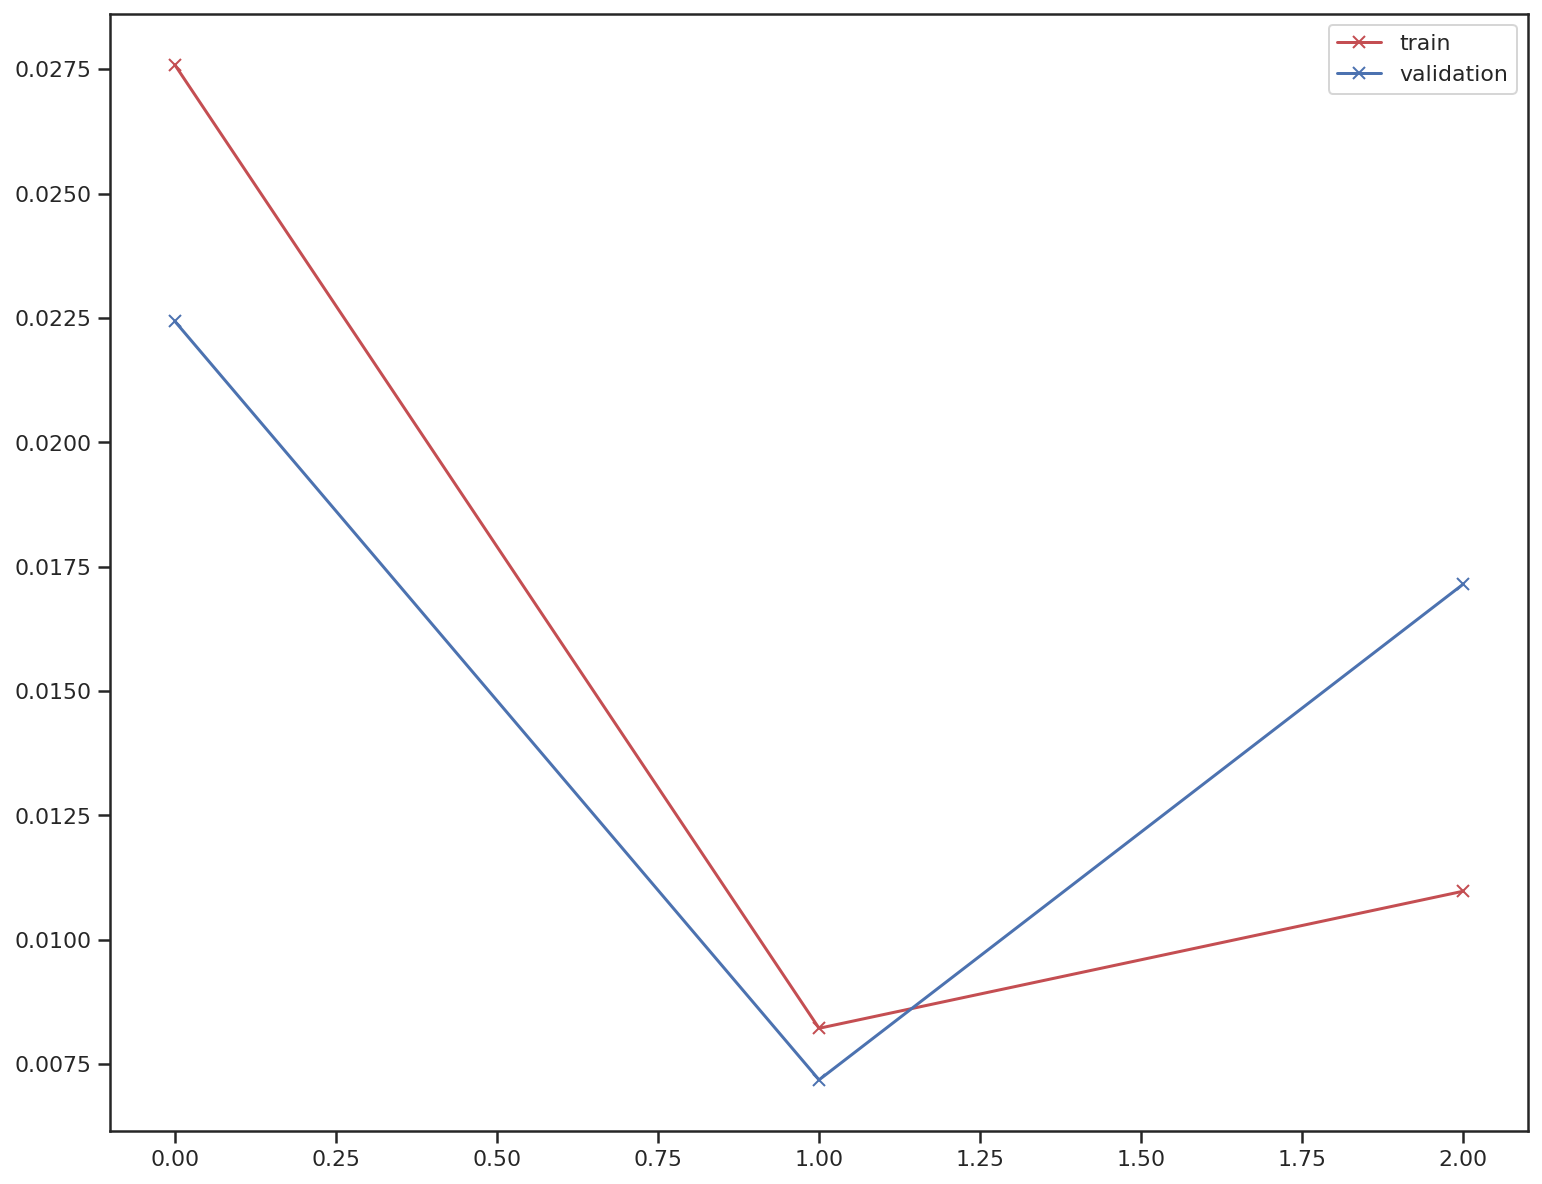

In [46]:
plt.plot(range(0, n_epochs), train_loss, 'rx-', label='train')
plt.plot(range(0, n_epochs), val_loss, 'bx-', label='validation')
plt.legend()

Text(0.5, 1.0, 'PanCancer Train: Siamese')

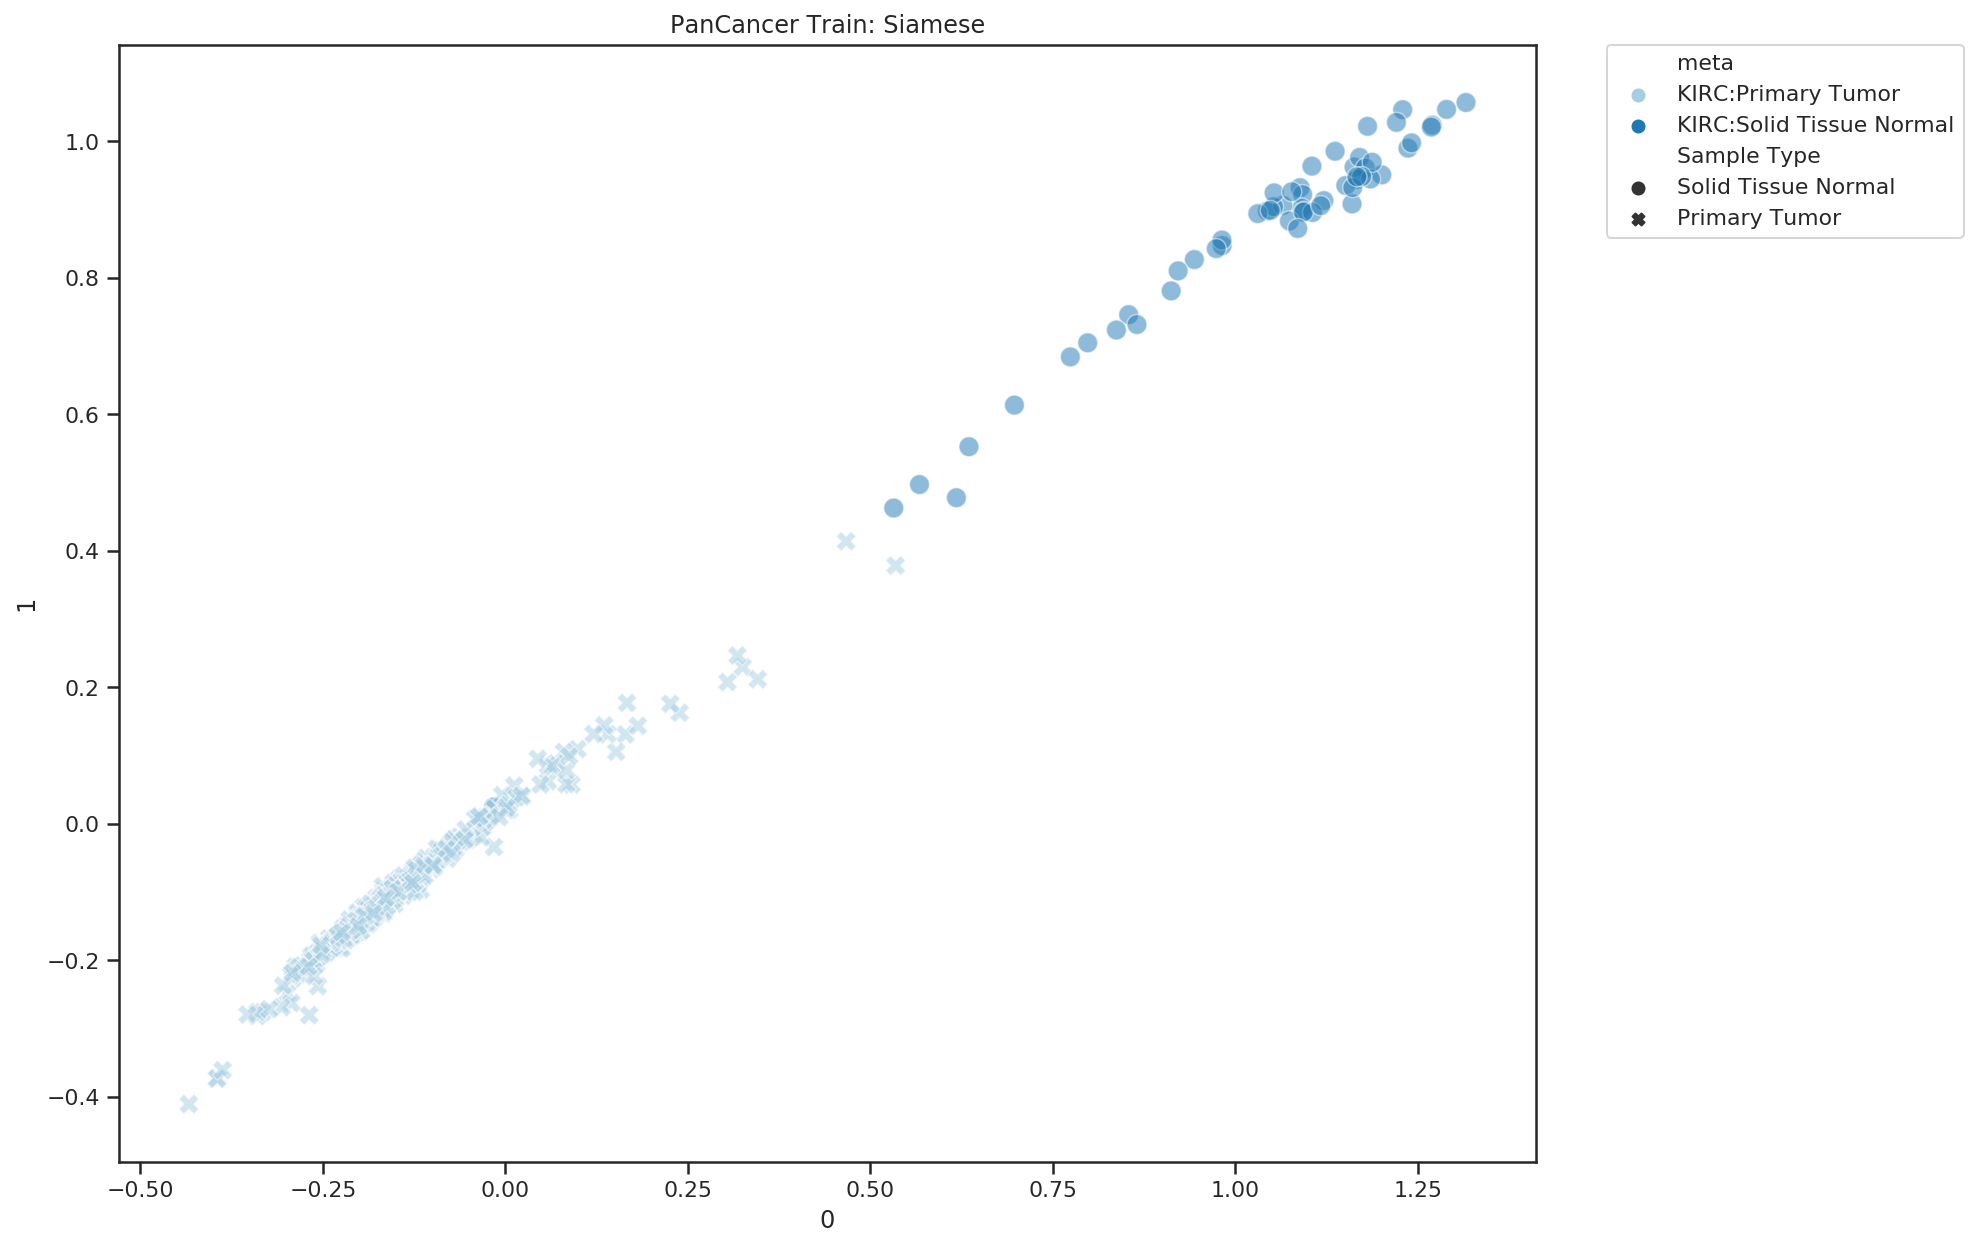

In [47]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(siamese_train_dataset.train_data, siamese_train_dataset.labels, model)
vis.sns_plot_embeddings(train_embeddings_cl, train_labels_cl, exp.labels_dict, 
                        hue='meta', style='Sample Type', alpha=0.5)
plt.title('PanCancer Train: Siamese')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 1.0, 'PanCancer Test: Siamese')

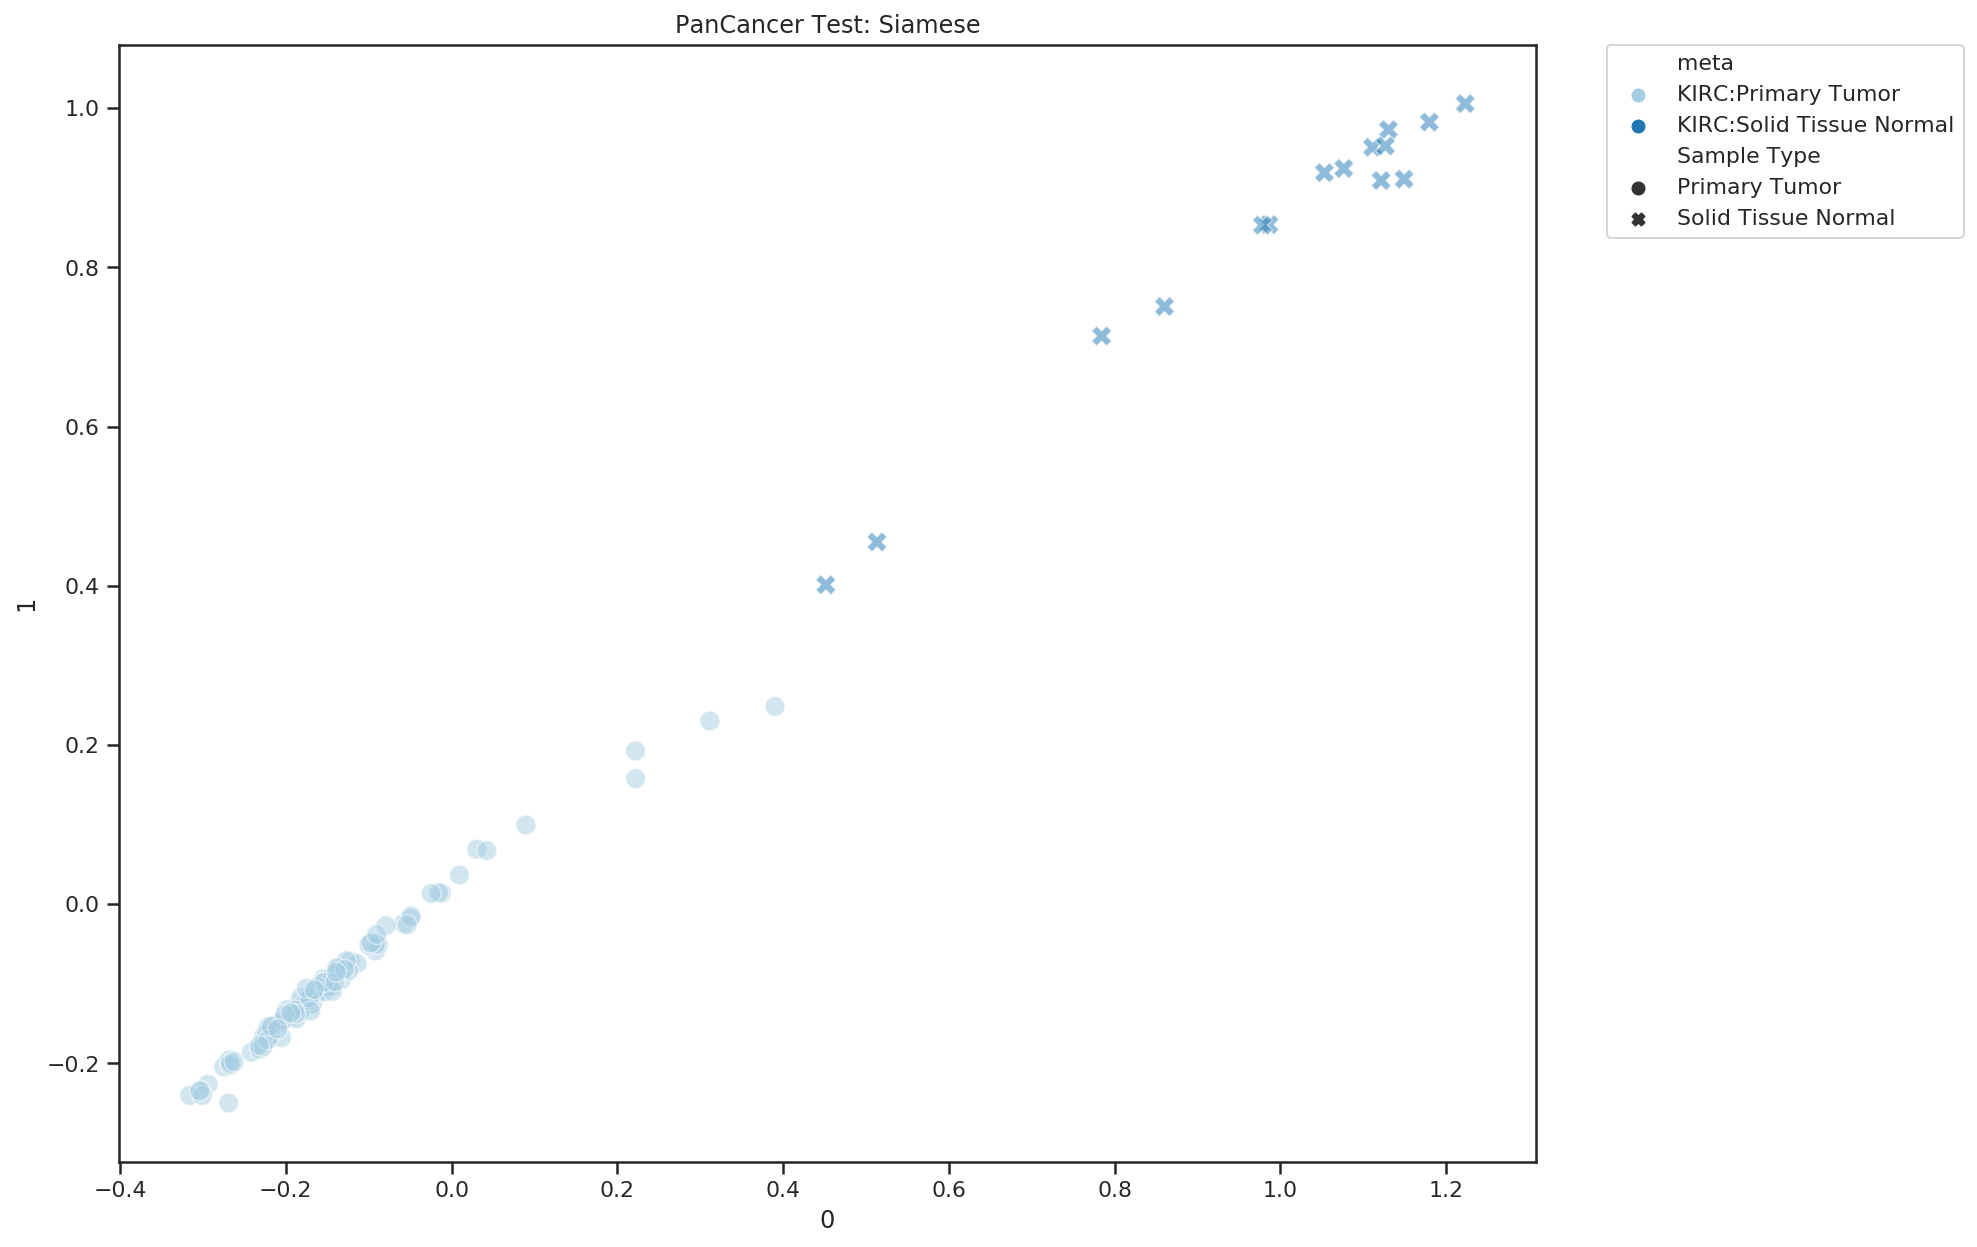

In [48]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(siamese_test_dataset.test_data, siamese_test_dataset.labels, model)
vis.sns_plot_embeddings(val_embeddings_baseline, val_labels_baseline, exp.labels_dict, 
                        hue='meta', style='Sample Type', alpha=0.5)
plt.title('PanCancer Test: Siamese')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [20]:
holdout_data, holdout_labels = exp.get_data(tcga, subset="holdout", dtype=np.float32)
siamese_holdout_dataset = SiameseDataset(data=holdout_data,
                                         labels=holdout_labels,
                                         train=True)

Text(0.5, 1.0, 'PanCancer Holdout: SKCM:Metastatic')

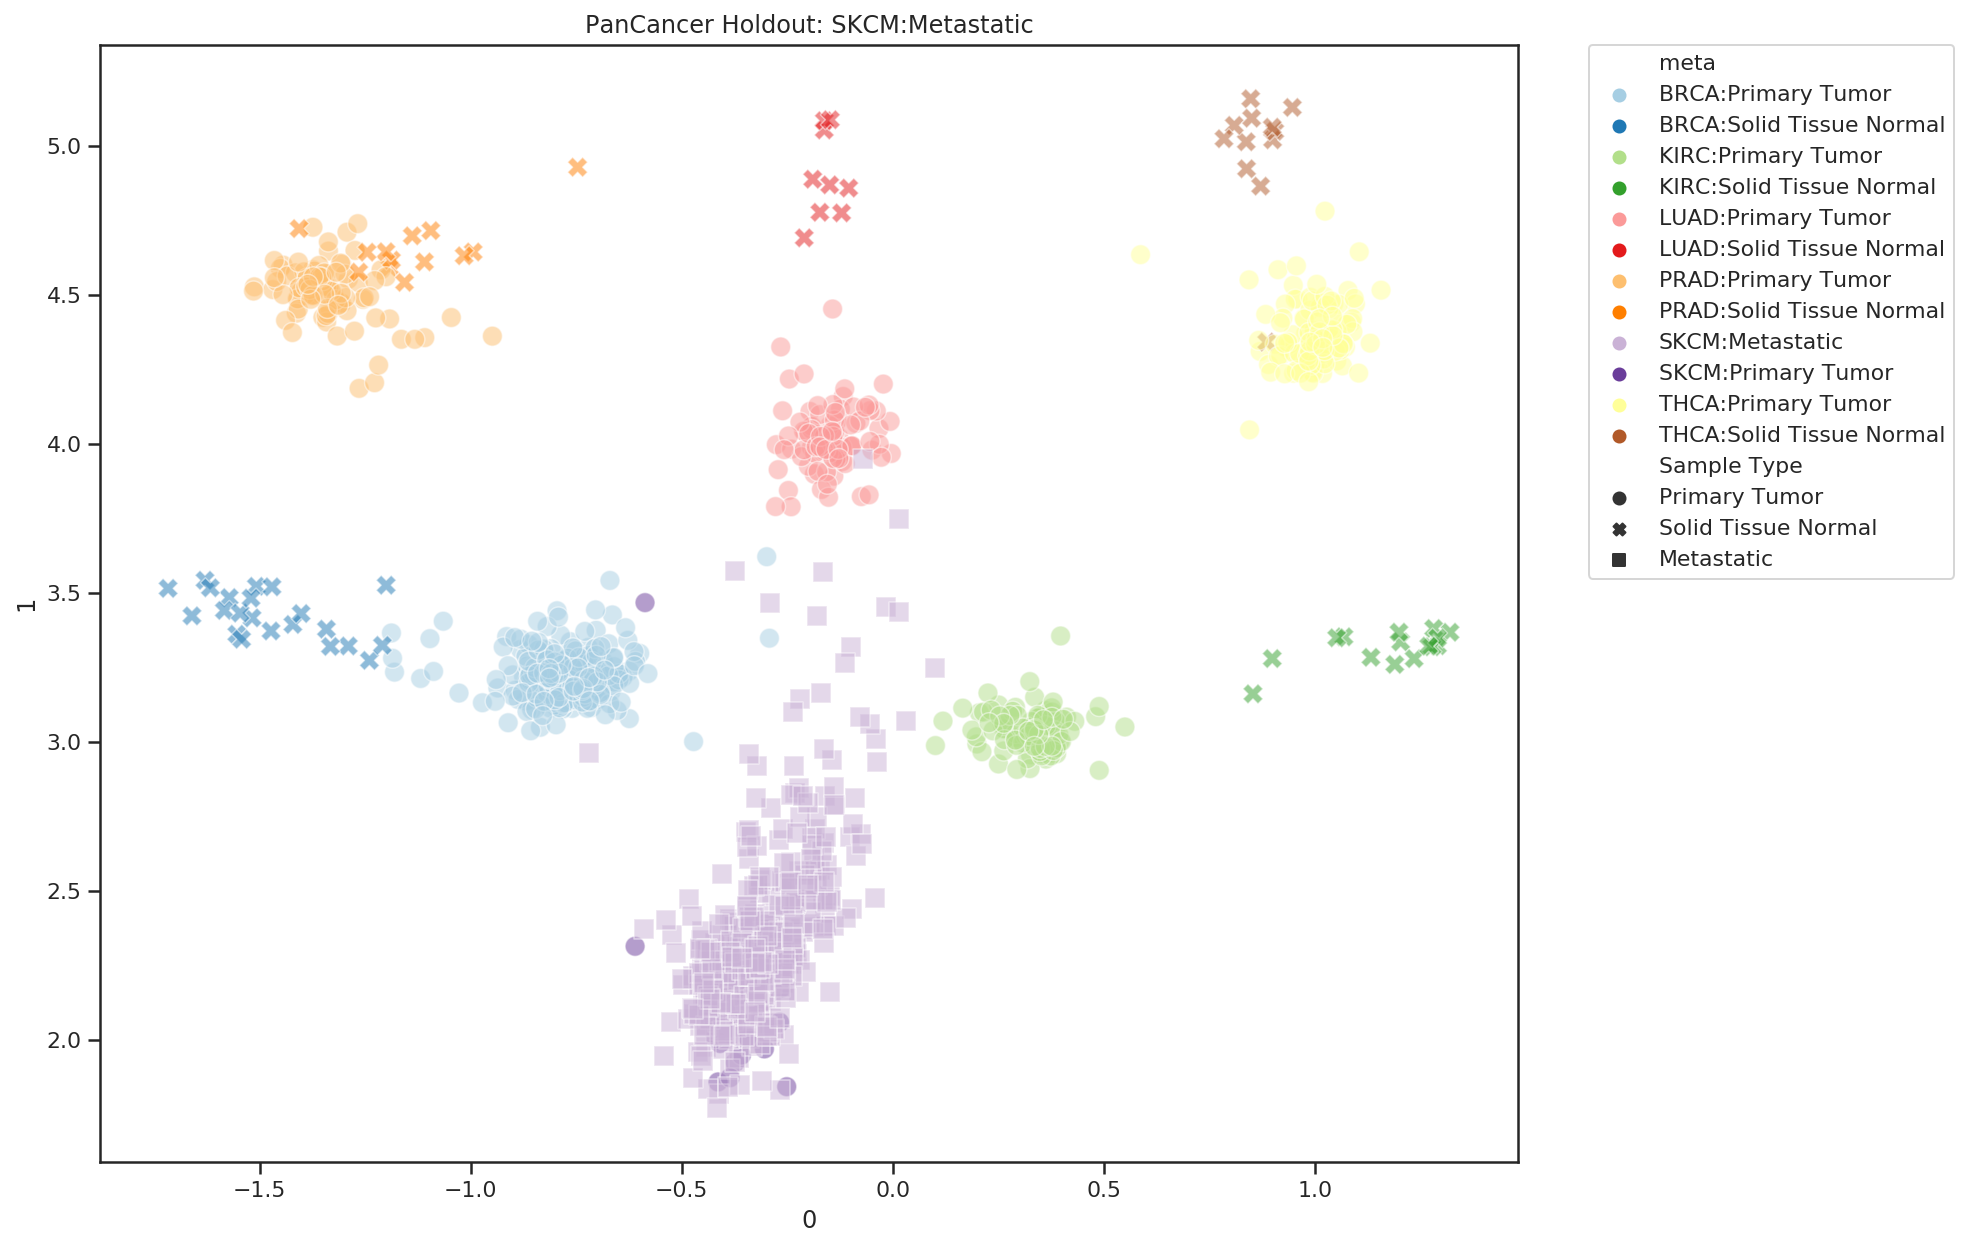

In [21]:
holdout_embeddings_baseline, holdout_labels_baseline = vis.extract_embeddings(siamese_holdout_dataset.train_data, siamese_holdout_dataset.labels, model)
# combine with validation for plotting
comb_embeddings_baseline = np.concatenate((val_embeddings_baseline, holdout_embeddings_baseline))
comb_labels_baseline = np.concatenate((val_labels_baseline, holdout_labels_baseline))
vis.sns_plot_embeddings(comb_embeddings_baseline, comb_labels_baseline, exp.labels_dict, 
                        hue='meta', style='Sample Type', alpha=0.5)
plt.title('PanCancer Holdout: SKCM:Metastatic')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## CCLE Data for Projection

In [22]:
ccle_file = [os.path.join(base, "CCLE/CCLE_counts.tsv.gz")]

In [23]:
ccle_meta = pd.read_csv(os.path.join(base, "CCLE/CCLE_GDC_Metadata.tsv.gz"), sep="\t")

In [24]:
ccle = readGCP(ccle_file, biotype='protein_coding', mean=True)

In [25]:
# combine samples
ccle = pd.concat(ccle.values())

In [26]:
# normalization
ccle = uq_norm(ccle)
ccle = ccle.transform(np.log1p)

In [27]:
# rename ids to match DepMap 'stripped cell line name'
ccle_ids = ["".join(filter(str.isalnum, i[1])).upper() for i in ccle.index.str.split(".")]
ccle.index = ccle_ids
# drop duplicately named cell lines
ccle = ccle.reset_index().drop_duplicates('index').set_index('index')

In [28]:
# DepMap CCLE metadata
ccle_meta = pd.read_csv('/srv/nas/mk2/projects/pan-cancer/DepMap/CCLE/sample_info_v2.csv', sep=",")

In [29]:
ccle_hierarchy = OrderedDict({'disease':['Breast Cancer', 'Lung Cancer', 'Kidney Cancer', 'Thyroid Cancer', 'Prostate Cancer', 'Skin Cancer'],
                              'primary_or_metastasis':['Primary', 'Metastasis']})

In [30]:
ccle_meta.shape
ccle_meta = ccle_meta[ccle_meta['stripped_cell_line_name'].isin(ccle.index)]
ccle_meta.shape

(1775, 24)

(881, 24)

In [31]:
# Define experiment
ccle_exp = Experiment(meta_data=ccle_meta,
                      hierarchy=ccle_hierarchy,
                      index='stripped_cell_line_name',
                      cases='CCLE_Name',
                      min_samples=1)

In [32]:
ccle_exp.holdout(holdout=ccle_exp.labels_dict.values())

In [33]:
ccle_data, ccle_labels = ccle_exp.get_data(ccle, subset="holdout", dtype=np.float32)
siamese_ccle_dataset = SiameseDataset(data=ccle_data,
                                         labels=ccle_labels,
                                         train=True)

In [34]:
ccle_embeddings_baseline, ccle_labels_baseline = vis.extract_embeddings(siamese_ccle_dataset.train_data, siamese_ccle_dataset.labels, model)

Text(0.5, 1.0, 'PanCancer CCLE Projection')

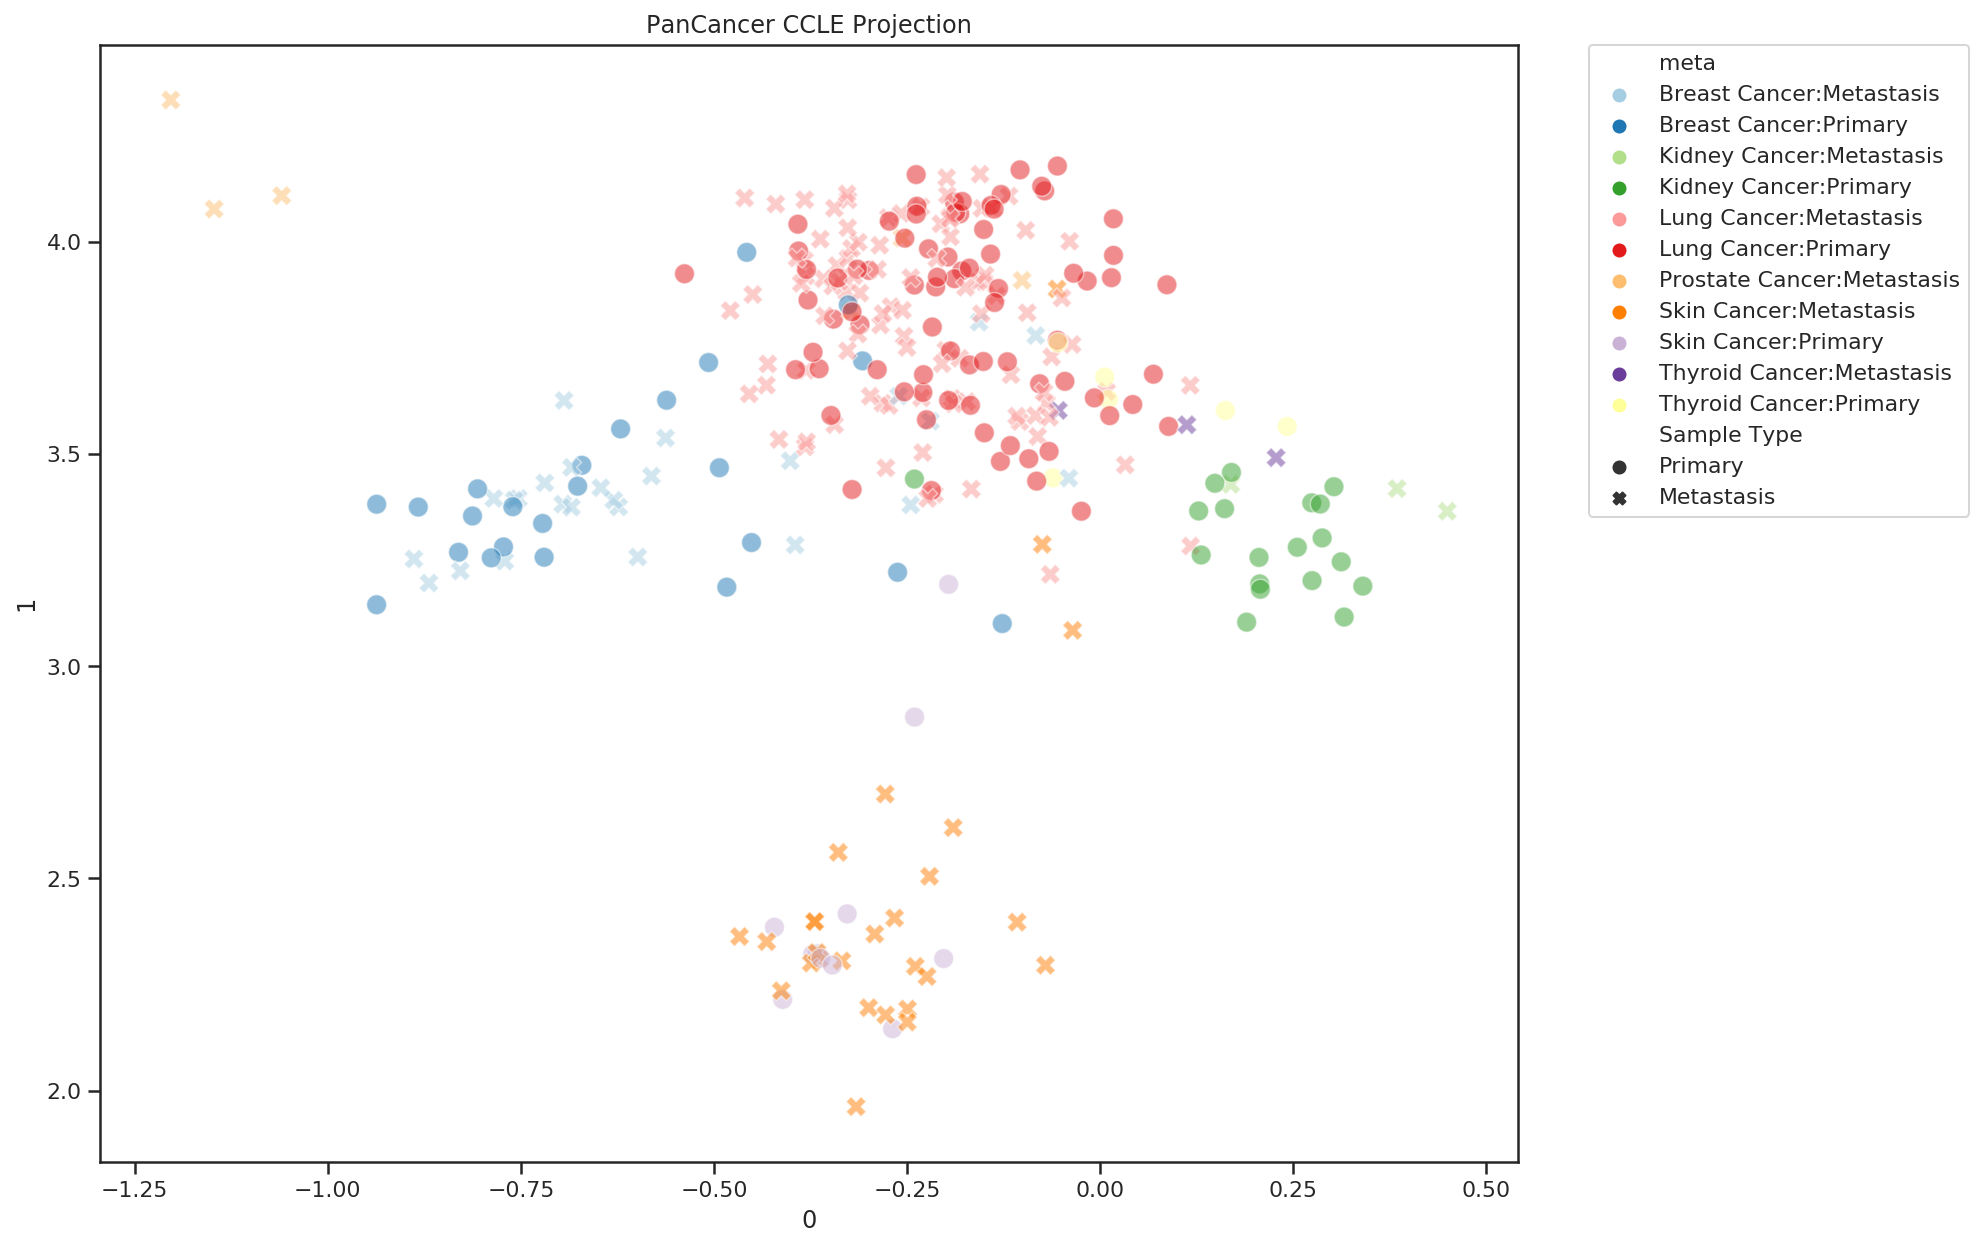

In [35]:
vis.sns_plot_embeddings(ccle_embeddings_baseline, ccle_labels_baseline, ccle_exp.labels_dict, 
                        hue='meta', style='Sample Type', alpha=0.5)
plt.title('PanCancer CCLE Projection')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Visualize

In [36]:
tcga_embeddings = pd.DataFrame(val_embeddings_baseline, columns=[0, 1])
tcga_embeddings['id'] = exp.test_meta.index.values
tcga_embeddings['meta'] = exp.test_meta['meta'].values
tcga_embeddings['source'] = np.repeat('TCGA', len(tcga_embeddings))
tcga_embeddings['size'] = np.repeat(20, len(tcga_embeddings))

In [37]:
ccle_embeddings = pd.DataFrame(ccle_embeddings_baseline, columns=[0, 1])
ccle_embeddings['id'] = ccle_exp.holdout_meta.index.values
ccle_embeddings['meta'] = ccle_exp.holdout_meta['meta'].values
ccle_embeddings['source'] = np.repeat('CCLE', len(ccle_embeddings))
ccle_embeddings['size'] = np.repeat(70, len(ccle_embeddings))

In [38]:
all_embeddings = pd.concat([tcga_embeddings, ccle_embeddings])
all_embeddings.shape

(1029, 6)

In [43]:
ccle_exp.holdout

dict_values(['Breast Cancer:Metastasis', 'Breast Cancer:Primary', 'Kidney Cancer:Metastasis', 'Kidney Cancer:Primary', 'Lung Cancer:Metastasis', 'Lung Cancer:Primary', 'Prostate Cancer:Metastasis', 'Skin Cancer:Metastasis', 'Skin Cancer:Primary', 'Thyroid Cancer:Metastasis', 'Thyroid Cancer:Primary'])

Text(0.5, 1.0, 'PanCancer CCLE Projection')

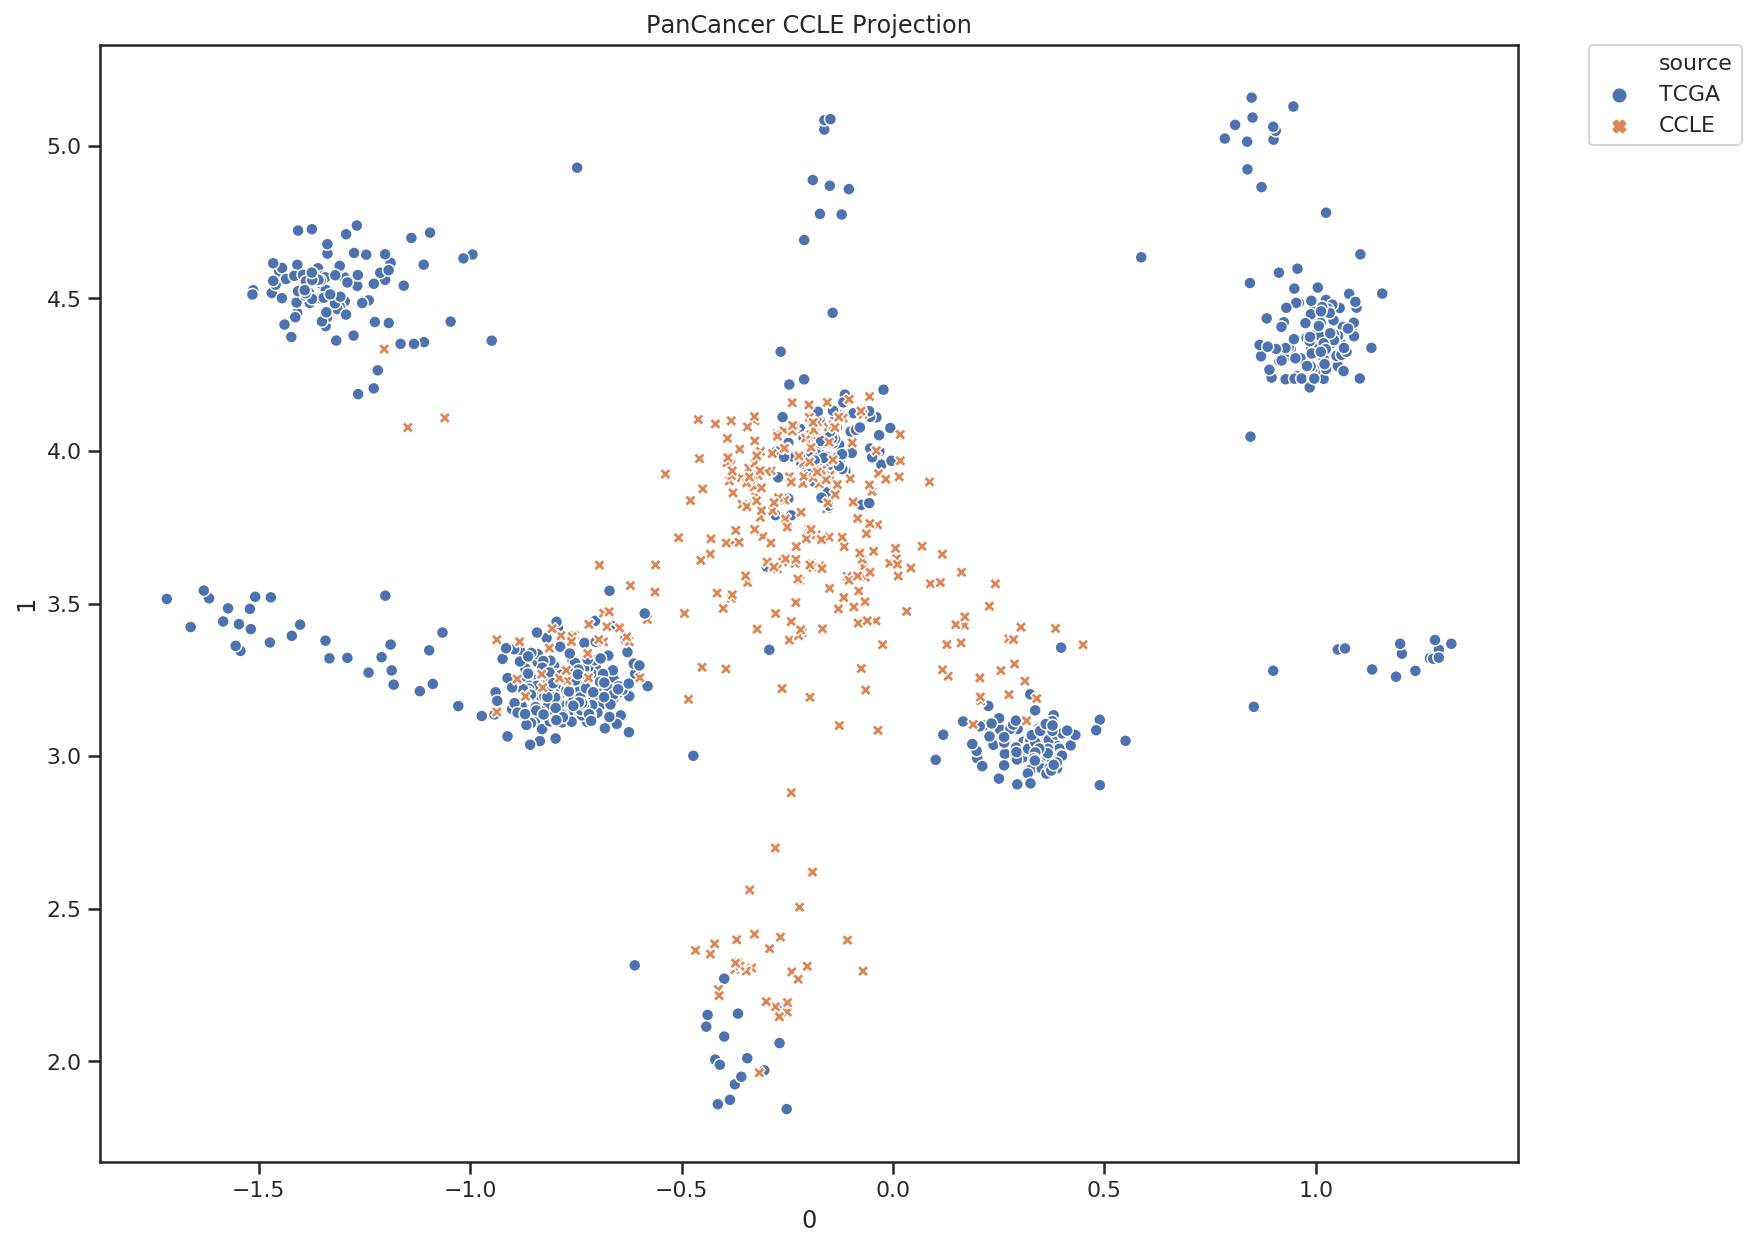

In [44]:
keep = ["Breast Cancer:Primary", "Breast Cancer:Metastasis"]
remove = np.setdiff1d(np.array(ccle_exp.holdout), keep)
select_embeddings = all_embeddings[~all_embeddings['meta'].isin(remove)].sort_values(by='meta')

sns.scatterplot(x=0, y=1, hue='source', style='source', data=select_embeddings)
plt.title('PanCancer CCLE Projection')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 1.0, 'PanCancer CCLE Projection')

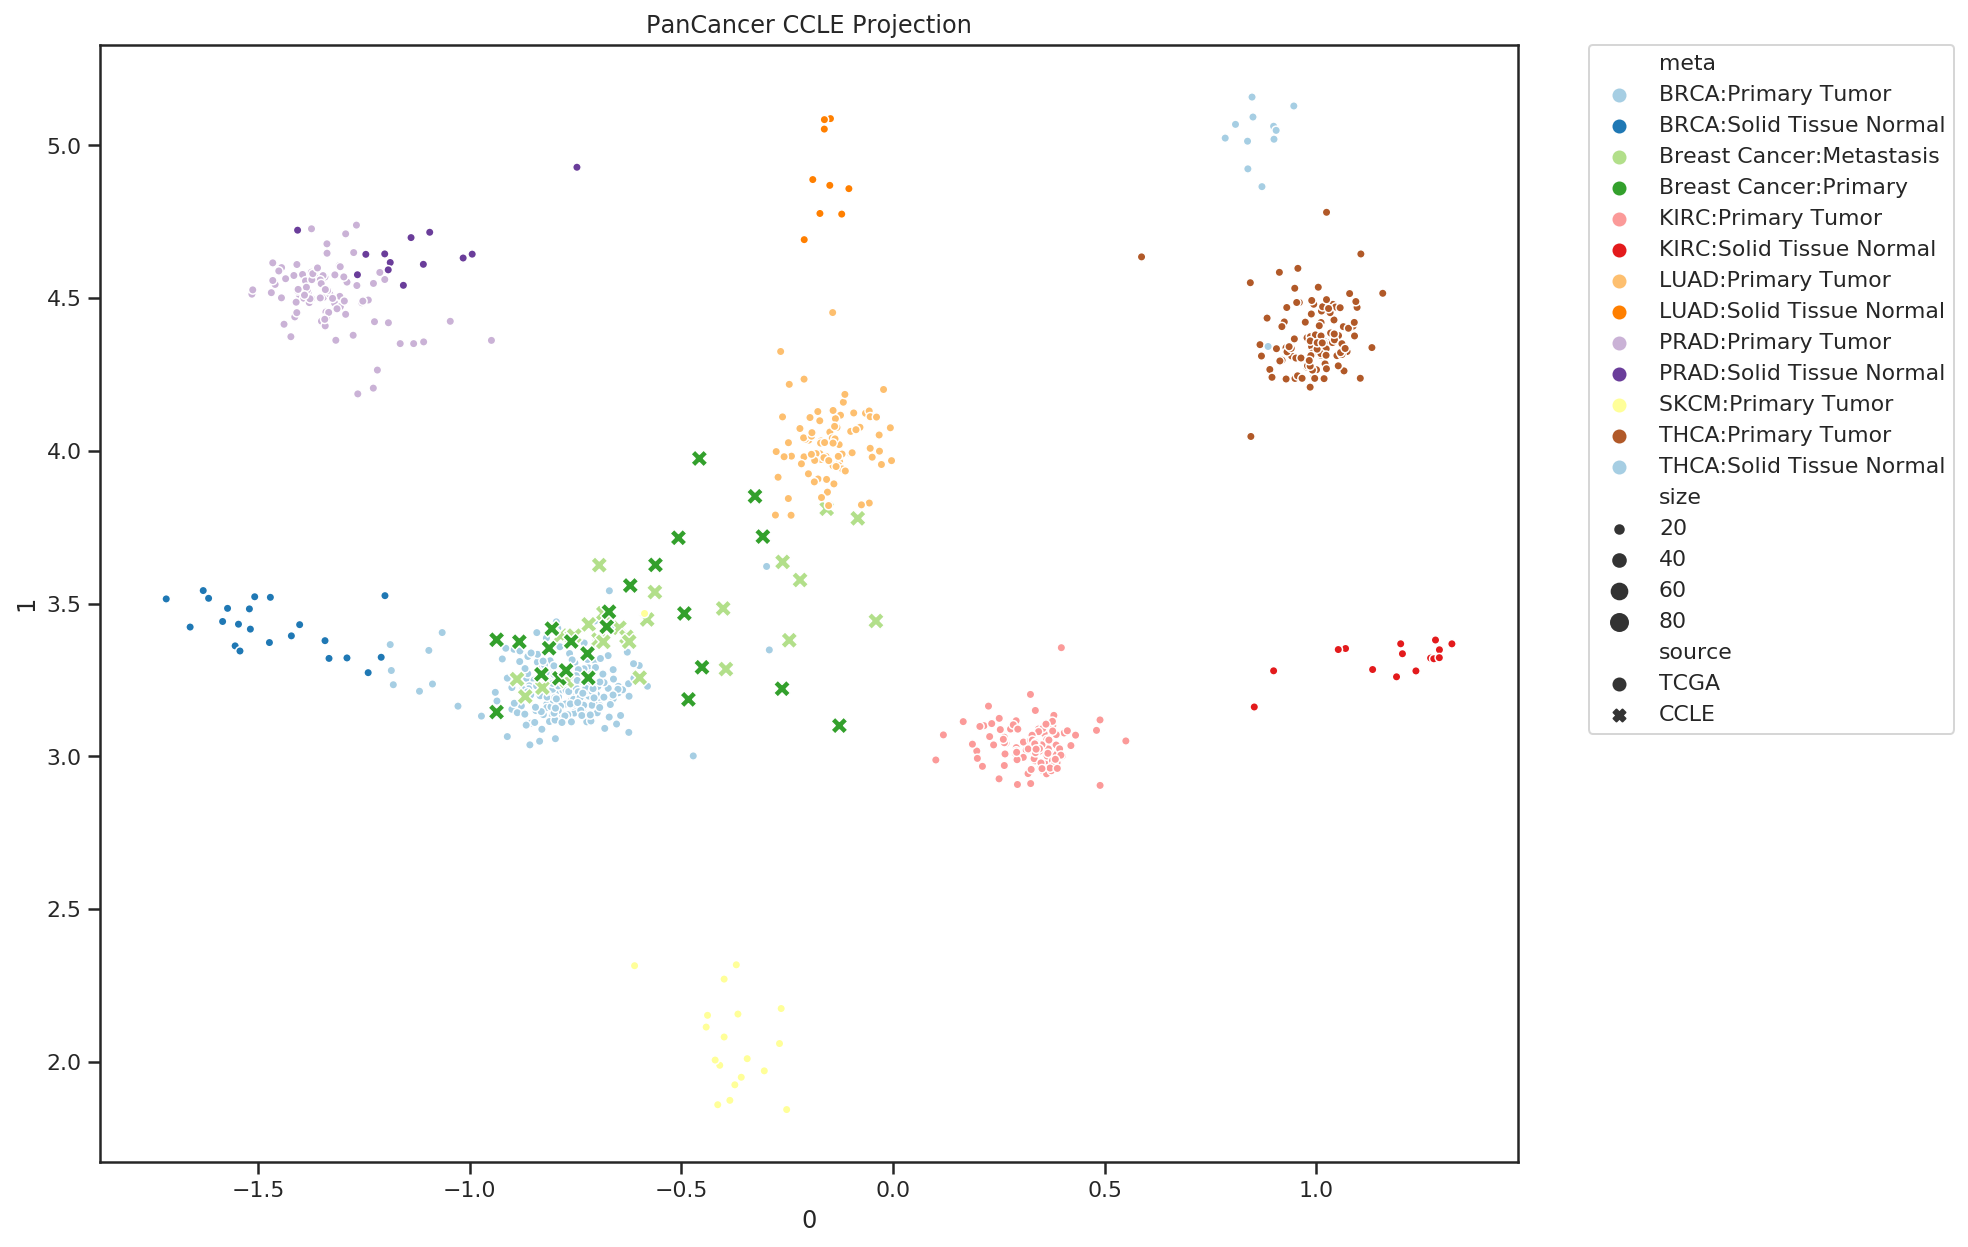

In [47]:
keep = ["Breast Cancer:Primary", "Breast Cancer:Metastasis"]
remove = np.setdiff1d(np.array(list(ccle_exp.holdout)), keep)
select_embeddings = all_embeddings[~all_embeddings['meta'].isin(remove)].sort_values(by='meta')

sns.scatterplot(x=0, y=1, hue='meta', style='source', palette='Paired', size='size', data=select_embeddings)
plt.title('PanCancer CCLE Projection')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [48]:
list(ccle_exp.holdout)

['Breast Cancer:Metastasis',
 'Breast Cancer:Primary',
 'Kidney Cancer:Metastasis',
 'Kidney Cancer:Primary',
 'Lung Cancer:Metastasis',
 'Lung Cancer:Primary',
 'Prostate Cancer:Metastasis',
 'Skin Cancer:Metastasis',
 'Skin Cancer:Primary',
 'Thyroid Cancer:Metastasis',
 'Thyroid Cancer:Primary']

Text(0.5, 1.0, 'PanCancer CCLE Projection')

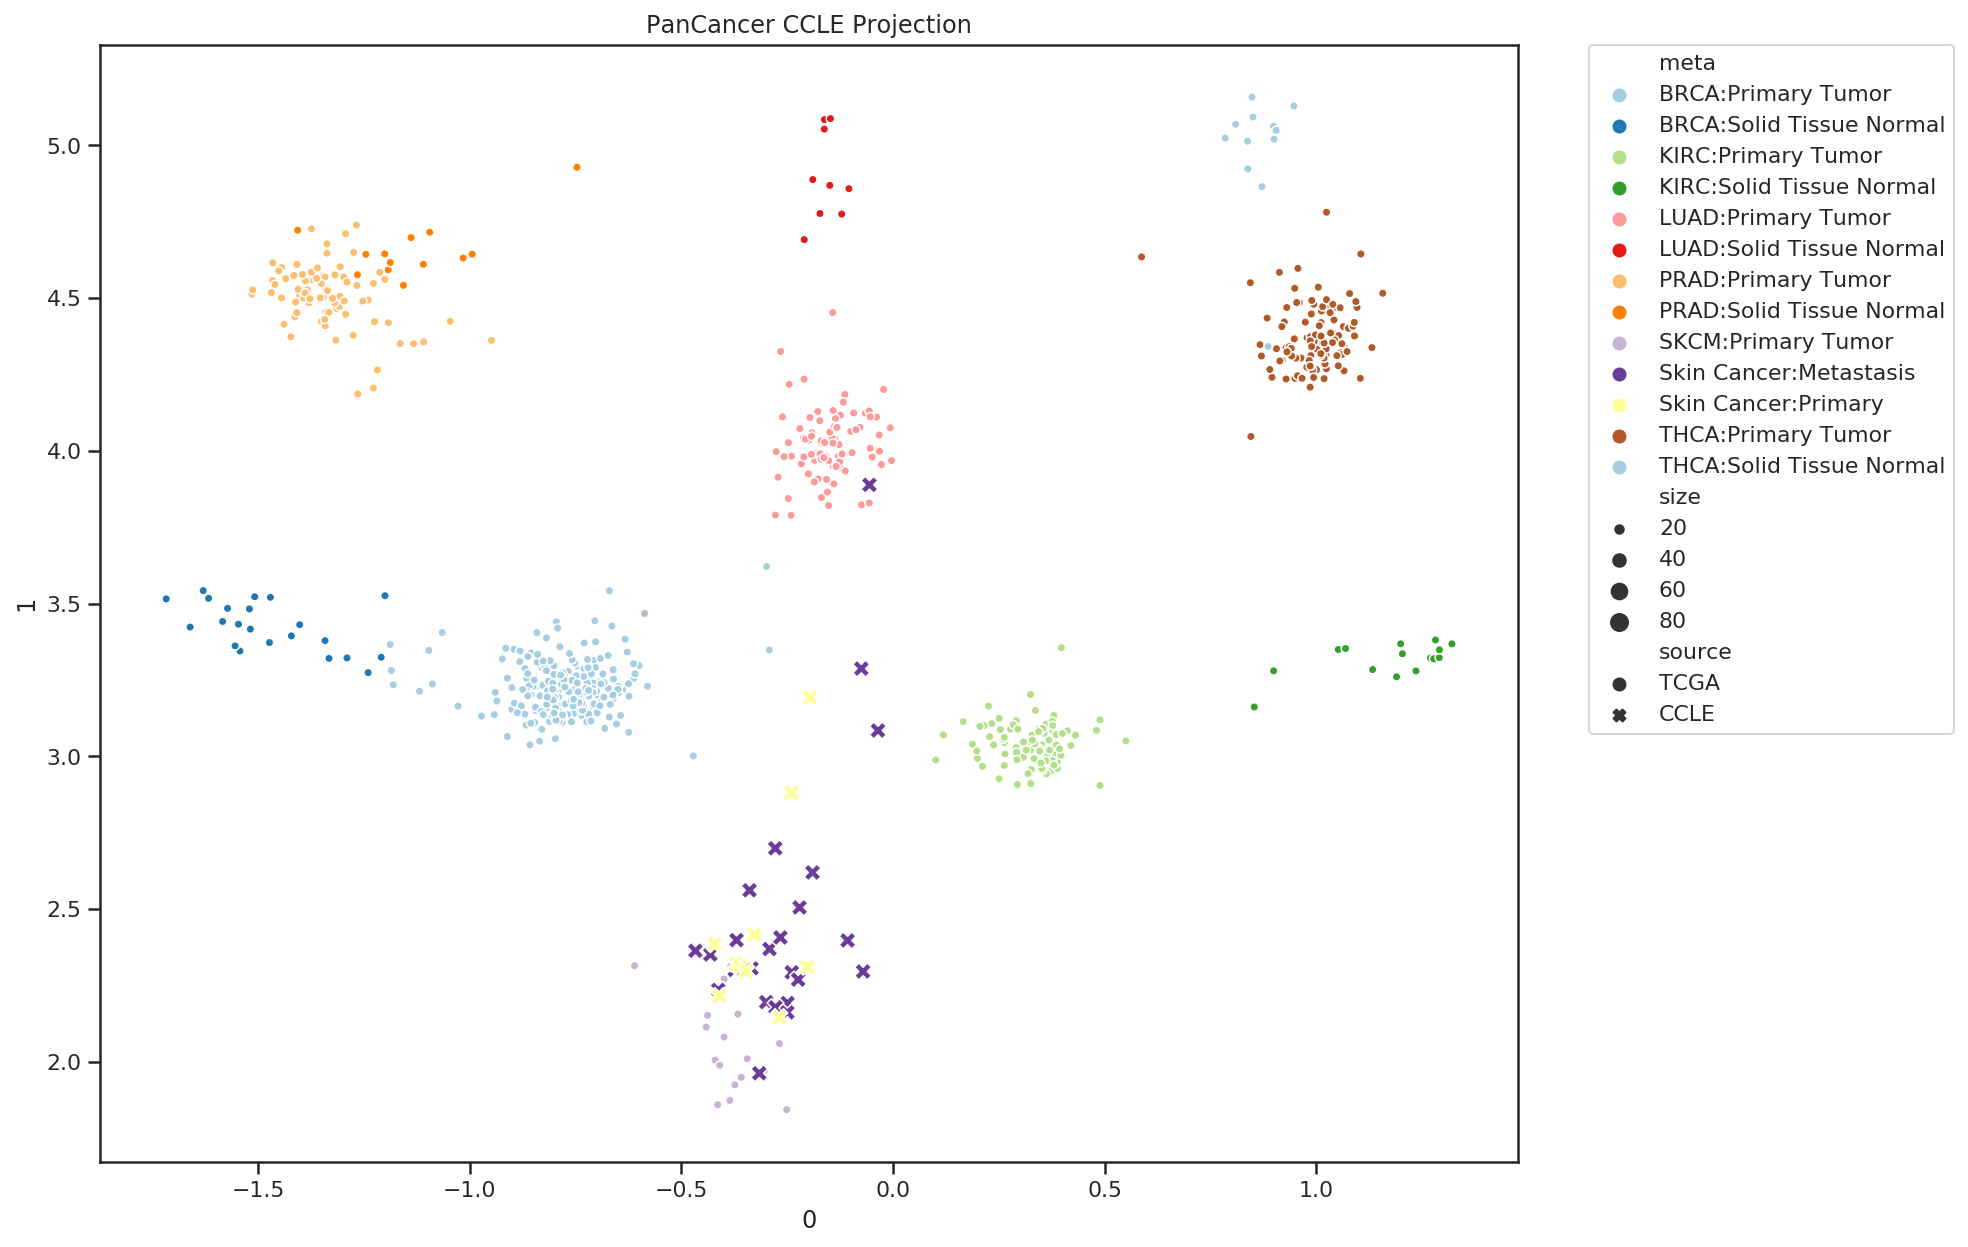

In [49]:
keep = ["Skin Cancer:Primary", "Skin Cancer:Metastasis"]
remove = np.setdiff1d(np.array(list(ccle_exp.holdout)), keep)
select_embeddings = all_embeddings[~all_embeddings['meta'].isin(remove)].sort_values(by='meta')

sns.scatterplot(x=0, y=1, hue='meta', style='source', palette='Paired', size='size', data=select_embeddings)
plt.title('PanCancer CCLE Projection')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Evaluation

In [251]:
from sklearn.metrics import pairwise_distances

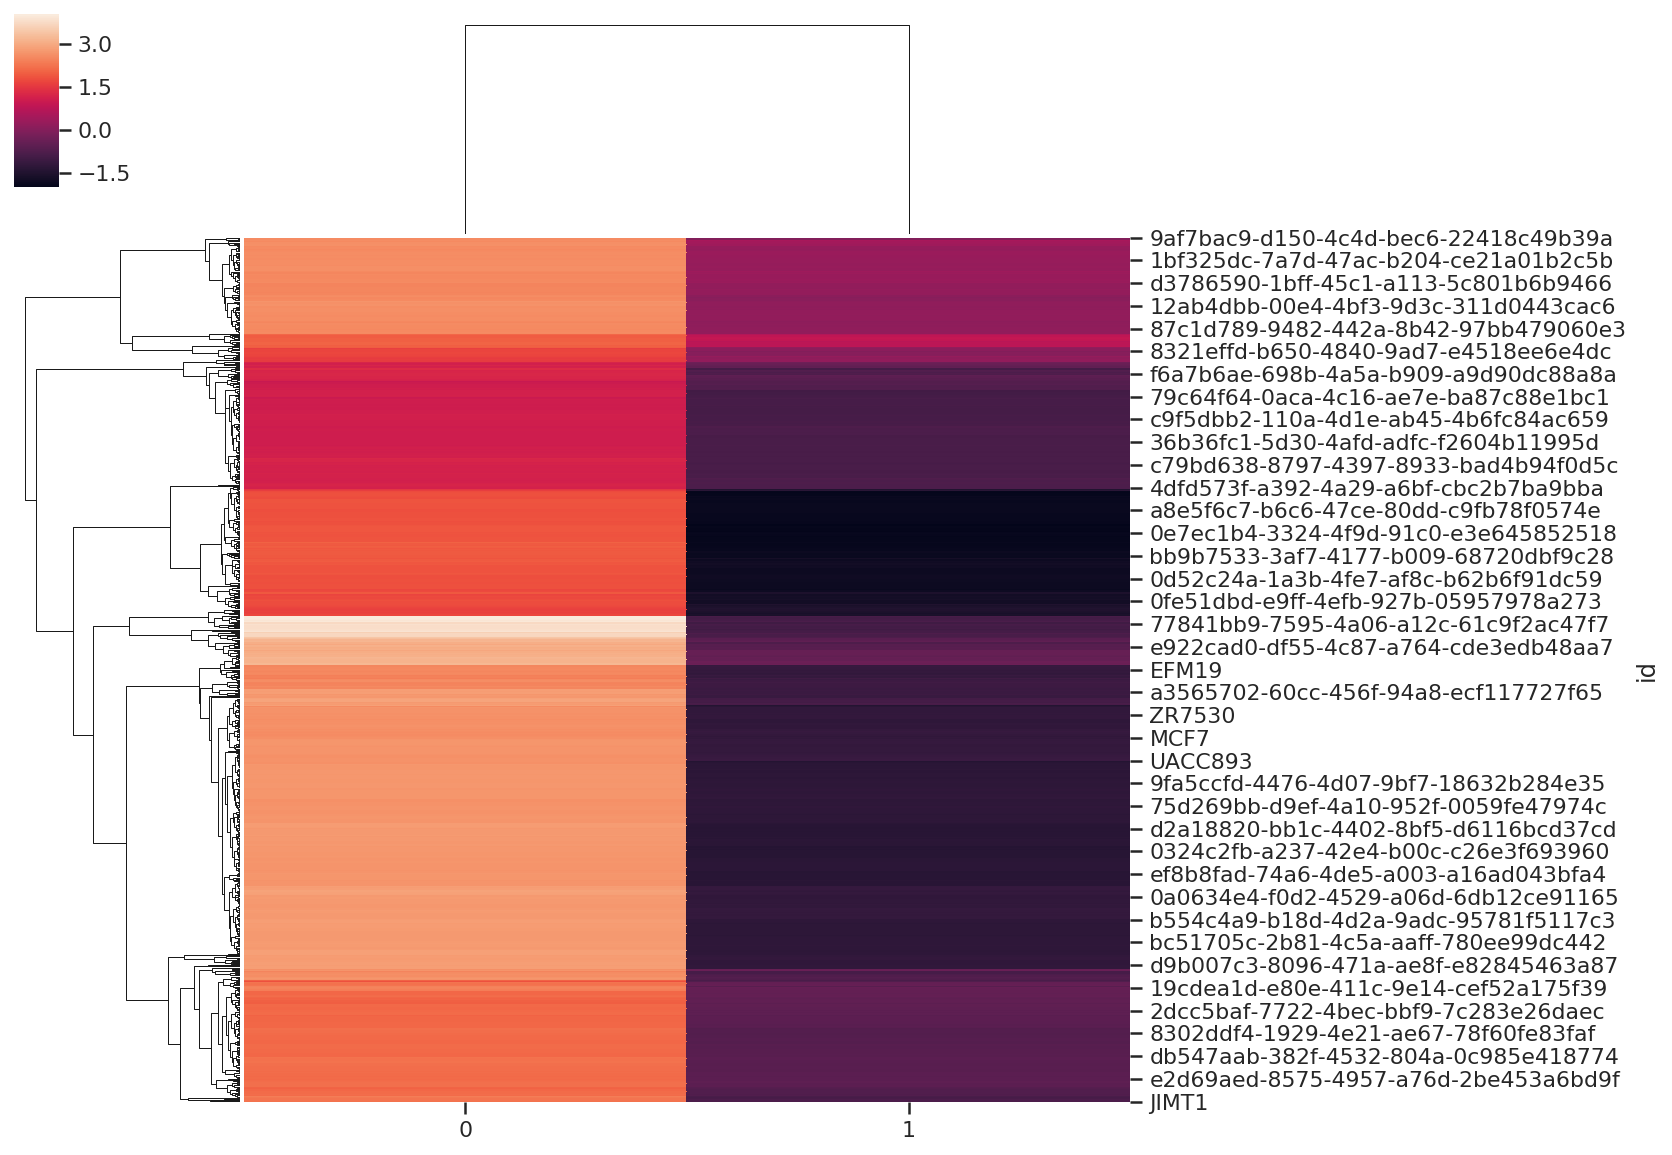

In [255]:
sns.clustermap(select_embeddings.set_index('id').loc[:,[0,1]])

In [253]:
select_distances = pd.DataFrame(pairwise_distances(select_embeddings.set_index('id').loc[:,[0,1]], metric='euclidean'),
                                index=select_embeddings['id'],
                                columns=select_embeddings['id'])